In [1]:
from __future__ import absolute_import, division

import os
import urllib, cStringIO

import pymongo as pm
import math
from numpy.linalg import norm

import numpy as np
import scipy.stats as stats
from sklearn.metrics import *
import pandas as pd
import json
import re
from joblib import dump, load

from PIL import Image
import base64
import sys

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from sklearn import linear_model, datasets, neighbors, svm
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from IPython.display import clear_output
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
feature_dir = os.path.abspath(os.path.join(proj_dir,'features'))
svg_dir = os.path.abspath(os.path.join(sketch_dir,'svg'))
png_dir = os.path.abspath(os.path.join(sketch_dir,'png'))

## feature dirs
quickdraw_dir = os.path.abspath(os.path.join(feature_dir,'quickdraw'))
intact_feature_dir = os.path.abspath(os.path.join(feature_dir,'intact'))
lesion_feature_dir = os.path.abspath(os.path.join(feature_dir,'lesion'))
collab_feature_dir = os.path.abspath(os.path.join(lesion_feature_dir,'collab'))
humanOnly_feature_dir = os.path.abspath(os.path.join(collab_feature_dir,'human_only'))
robotOnly_feature_dir = os.path.abspath(os.path.join(collab_feature_dir,'robot_only'))
solo_feature_dir = os.path.abspath(os.path.join(lesion_feature_dir,'solo'))
even_feature_dir = os.path.abspath(os.path.join(solo_feature_dir,'even_only'))
odd_feature_dir = os.path.abspath(os.path.join(solo_feature_dir,'odd_only'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
import rendering_helpers as srh
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)
reload(srh)

<module 'rendering_helpers' from 'rendering_helpers.pyc'>

### helpers

In [3]:
def cleanup_df(X):
    if 'Unnamed: 0' in X.columns:
        X = X.drop(columns=['Unnamed: 0'])
    return X

def flatten(x):
    return [item for sublist in x for item in sublist]

def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def meancenter(X):
    X = X - X.mean(0)
    return X

def load_features_and_meta(feat_dir):
    
    F = np.load(os.path.join(feat_dir,'FEATURES_FC6_sketch_no-channel-norm.npy'))
    F = pd.DataFrame(F)
    feat_cols = [str(i) for i in np.arange(4096)]
    F.columns = feat_cols

    ## load in metadata
    M = pd.read_csv(os.path.join(feat_dir,'METADATA_sketch.csv'))

    ## break sketch_id into relevant attributes
    attributes = ['gameID','className','repetition','trialNum','condition']
    for i,a in enumerate(attributes):    
        M[a] = M['sketch_id'].apply(lambda x: x.split('_')[i])

    ## combine into single composite dataframe
    C = pd.concat([M,F],axis=1)      
    C['game_class_trial'] = pd.Series(['{}_{}_{}'.format(i,j,k) for (i,j,k) in zip(C['gameID'],C['className'],C['repetition'])])        
    
    return C


def concat_clf_probs(clf,C):    
    '''
    clf is classifier object (trained on quickdraw)
    C is dataframe that already combines metadata and features
    '''

    feat_cols = [str(i) for i in np.arange(4096)]

    ## extract probabilities and predictions from classifier
    cats = clf.classes_
    probs = clf.predict_proba(C[feat_cols])
    preds = clf.predict(C[feat_cols])

    ## convert probs into dataframe
    P = pd.DataFrame(probs)
    P.columns = cats
    
    H = pd.DataFrame(preds)
    H.columns = ['predClass']

    ## attach probabilites to meta dataframe
    CP = pd.concat([C,P,H],axis=1)    
    CP = CP.assign(correct=(CP['className']==CP['predClass']).astype(int))
    
    return CP

def get_lite_dataframe(DP): 
    '''
    input: dataframe that is the output of concat_clf_probs, containing metadata, features, and clf probs 
    output: "lite" version that preserves the most important columns: sketch_id, className, condition, clf probs
    '''
    DP_lite = DP[['sketch_id'] + ['className'] + ['condition'] + list(cats)]
    return DP_lite

def wide_to_long(D):
    '''
    convert to format that plays well with seaborn catplot
    '''    
    DP_lite = get_lite_dataframe(D)

    ## melt wide to long
    DP_long = pd.melt(DP_lite, 
                  id_vars=['sketch_id','condition','className'],
                  value_vars=class_list,
                  value_name='prob') 
    
    return DP_long
   

def plot_probs_by_class(clf,D):
    '''
    input: D = a metadata+feature matrix, and classifier object
           clf = pretrained classifier weights
    output: plots probs by category and target class
    '''
    
    DP = concat_clf_probs(clf,D)
    DP_lite = get_lite_dataframe(DP)
    DP_long = wide_to_long(DP_lite)
    
    ## grouped bar plots to compare collab to solo for each target type
    fig = plt.figure()
    g = sns.catplot(data=DP_long, 
                    x='variable', 
                    y='prob', 
                    hue='condition', 
                    col='className',
                    col_wrap=4,
                    kind='bar',
                    palette='husl')
    g.set_xticklabels(rotation=90)
    g.set_xlabels('categories')
    g.set_titles("{col_name}")
    l = plt.ylim(0,0.6)    

    
def add_target_prob_column(CP):
    CP = CP.assign(target_prob = pd.Series([d[d['className']] for i,d in CP.iterrows()]))
    return CP 

def extract_target_prob(CP):
    return CP[['sketch_id']+['gameID']+['className']+['condition']+['repetition']+['target_prob']+['predClass']+['correct']]

def add_game_class_trial(C):
    C['game_class_trial'] = pd.Series(['{}_{}_{}'.format(i,j,k) for (i,j,k) in zip(C['gameID'],C['className'],C['repetition'])])        
    return C

def simplify_dataframes(clf,C):
    return add_game_class_trial(extract_target_prob(add_target_prob_column(concat_clf_probs(clf,C))))
    
def jsdiv(P, Q):
    """Compute the Jensen-Shannon divergence between two probability distributions.

    Input
    -----
    P, Q : array-like
        Probability distributions of equal length that sum to 1
    """

    def _kldiv(A, B):
        return np.sum([v for v in A * np.log2(A/B) if not np.isnan(v)])

    P = np.array(P)
    Q = np.array(Q)

    M = 0.5 * (P + Q)

    return 0.5 * (_kldiv(P, M) +_kldiv(Q, M))    



### outline of questions

- Does collaborative drawing yield recognizable drawings?
    - Compare overall recognizability of solo & collab drawings
    - Compare recognizability of intact collab drawing vs. data-lesioned versions, and compare to lesioning random strokes
- Compare within-sketch recognizability timecourse between collab and solo conditions
- Does collaborative drawing affect subsequent solo drawings of the same object?

### load in quickdraw features and compile

In [4]:
class_list = ['bear','cat','duck','lion','pig','rabbit','sheep','swan']

In [5]:
Q = []
for this_class in class_list:
    print 'Grabbing features from {}'.format(this_class)
    clear_output(wait=True)
    FEAT = np.load(os.path.join(quickdraw_dir,this_class,'FEATURES_FC6_sketch_no-channel-norm.npy'))
    FEAT = pd.DataFrame(FEAT)
    feat_cols = [str(i) for i in np.arange(4096)]
    FEAT.columns = feat_cols

    META = pd.read_csv(os.path.join(quickdraw_dir,this_class,'METADATA_sketch.csv'))
    assert META.shape[0]==FEAT.shape[0]
    META = META.assign(className = pd.Series(this_class).repeat(len(META)).reset_index(drop=True))
    META = META.assign(dataset = pd.Series('quickdraw').repeat(len(META)).reset_index(drop=True))
    META.drop(columns=['feature_ind'],inplace=True)
    D = pd.concat([META,FEAT],axis=1)
    if len(Q)==0:
        Q = D
    else:
        Q = pd.concat([Q,D],axis=0)
print 'Done!'        

Done!


In [6]:
## Retrain or load in pretrained weights?
retrain = True

print 'Splitting data for quickdraw classifier...'  
clear_output(wait=True)
from sklearn.model_selection import train_test_split
X = np.array(Q[feat_cols])
y = Q['className'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.1)
if retrain:
    startTime = datetime.now()

    print 'Started training quickdraw classifier...'    
    clear_output(wait=True)
    clf = linear_model.LogisticRegression(penalty='l2',
                                          C=1e-3,
                                          random_state=0,
                                          solver='lbfgs',
                                          multi_class='multinomial',
                                          max_iter=1500).fit(X_train, y_train) 
    print 'Finished training quickdraw classifier...'  
    endTime = datetime.now()
    total_time = endTime - startTime
    print 'total time: {}'.format(total_time)
    
    ## save classifier weights     
    dump(clf, 'quickdraw5k_collabdraw_clf.joblib')    

else:
    ## load in pretrained weights
    clf = load('quickdraw5k_collabdraw_clf.joblib')
    
print 'Accuracy on test data: {}'.format(clf.score(X_test, y_test))

Finished training quickdraw classifier...
total time: 0:08:50.662017
Accuracy on test data: 0.6255


In [7]:
reallyRun = 0
if reallyRun:
    start_time = datetime.now() 
    scores = cross_validate(clf, X_test, y_test,
                             cv=5, return_train_score=True)
    end_time = datetime.now()
    total_time = end_time - start_time
    print 'Scores: {}'.format(scores['test_score'])
    print 'total time: {}'.format(total_time)

#### recognition on quickdraw test split

In [8]:
## extract probabilities and predictions for quickdraw test split
cats = clf.classes_
probs = clf.predict_proba(X_test)
print 'Accuracy on test split: {}'.format(clf.score(X_test, y_test))

## construct dataframe
PQ = pd.DataFrame(probs)
PQ.columns = cats
PQ['className'] = y_test

## add index column to keep probs for same sketch together
PQ = PQ.reset_index()

Accuracy on test split: 0.6255


<Figure size 432x288 with 0 Axes>

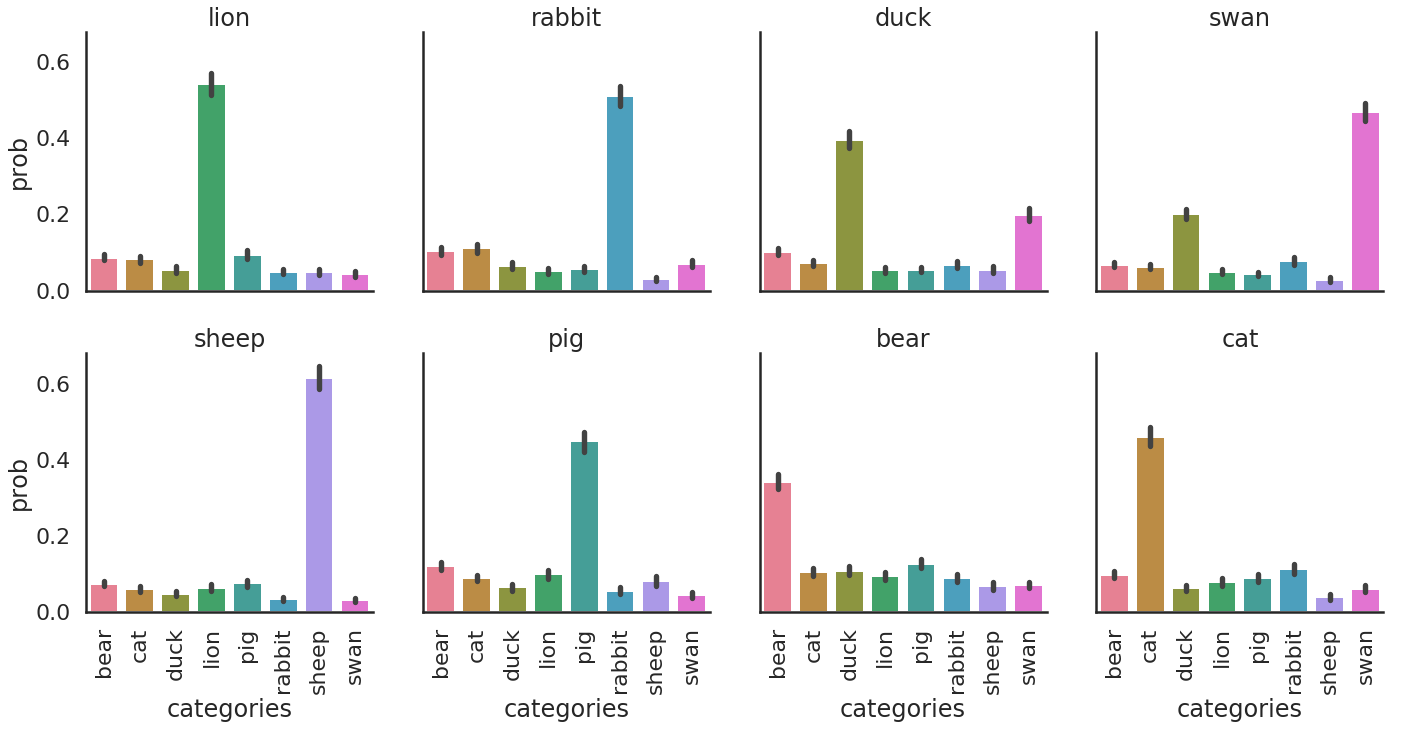

In [9]:
## melt wide to long
PQL = pd.melt(PQ, 
              id_vars=['index','className',],
              value_vars=class_list,
              value_name='prob')
## grouped bar plots to compare collab to solo for each target type
fig = plt.figure()
g = sns.catplot(data=PQL, 
                x='variable', 
                y='prob', 
                col='className',
                col_wrap=4,
                kind='bar',
                palette='husl')
g.set_xticklabels(rotation=90)
g.set_xlabels('categories')
g.set_titles("{col_name}")

### load in collabdraw features and metadata

In [10]:
C = load_features_and_meta(intact_feature_dir)

#### recognition accuracy on collabdraw experimental data

In [11]:
## extract probabilities and predictions from classifier
cats = clf.classes_
probs = clf.predict_proba(C[feat_cols])
preds = clf.predict(C[feat_cols])

## convert probs into dataframe
P = pd.DataFrame(probs)
P.columns = cats

H = pd.DataFrame(preds)
H.columns = ['predClass']

## attach probabilites to meta dataframe
CP = pd.concat([C,P,H],axis=1)
print 'Accuracy on test split: {}'.format(clf.score(CP[feat_cols], CP['className']))

## add column that represents the probability assigned to ground truth target object
CP2 = add_target_prob_column(get_lite_dataframe(CP))

## more sanity checks on target prob pulling out the correct number
## frequency with which target prob is the max should also match the accuracy (clf.score output above)
top_value = [np.max(d[class_list]) for i,d in CP2.iterrows()]
assert len([(i,j) for (i,j) in zip(CP2['target_prob'].values,top_value) if i==j])/len(top_value)

## subset dataframe & save out to run lmer in R
CP3 = CP[['sketch_id','gameID','className','condition','predClass']]
CP3 = CP3.assign(correct=[True if i==j else False for (i,j) in zip(CP3.className.values,CP3.predClass.values)])
CP3.to_csv(os.path.join(csv_dir,'collabdraw_preds.csv'))

Accuracy on test split: 0.455820476858


<Figure size 432x288 with 0 Axes>

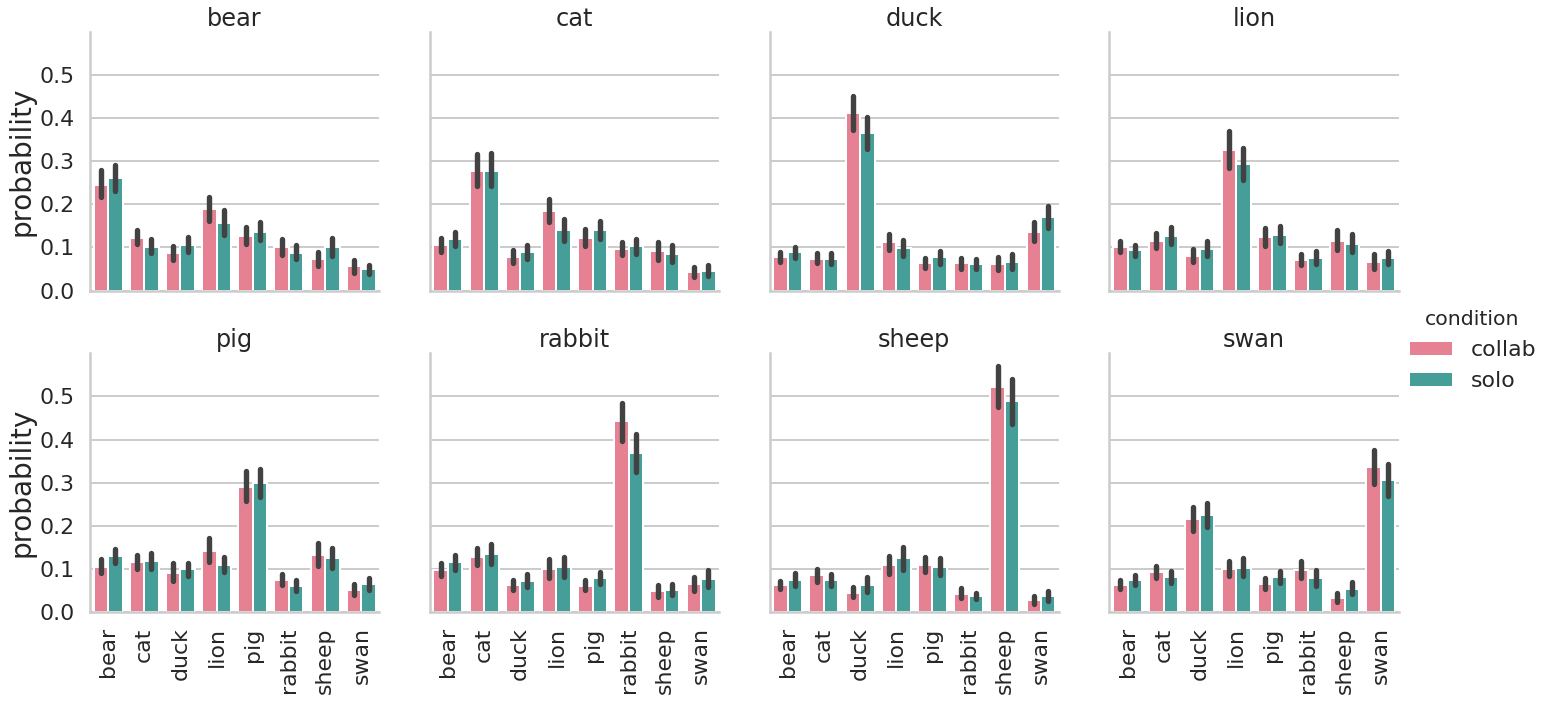

In [12]:
## construct dataframe with just the essentials
CLITE = CP2[['sketch_id'] + ['className'] + ['condition'] + list(cats)]
## melt wide to long
CLONG = pd.melt(CLITE, 
              id_vars=['sketch_id','condition','className'],
              value_vars=class_list,
              value_name='prob')
## grouped bar plots to compare collab to solo for each target type
tall_mode = False
if tall_mode:
    col_wrap = 2
    label='_tall'
else:
    col_wrap = 4
    label=''
fig = plt.figure()
sns.set_context('poster')
sns.set_style('whitegrid')
g = sns.catplot(data=CLONG, 
                x='variable', 
                y='prob', 
                hue='condition', 
                col='className',
                col_wrap=col_wrap,
                kind='bar',
                palette='husl',
                hue_order=['collab','solo'])
g.set_xticklabels(rotation=90)
g.set_xlabels('')
g.set_ylabels('probability',fontsize=28)
g.set_titles("{col_name}",fontsize=32)
g.set(yticks=np.arange(0,0.6,0.1))
out_path = os.path.join(plot_dir,'collab_solo_bar_byitem{}.pdf'.format(label))
plt.savefig(out_path)

In [13]:
## compute mean shannon-jensen divergence between collab and solo distributions
CLONGD = CLONG.groupby(['variable','condition','className'])['prob'].mean().reset_index()
true_jsd = []
for name, group in CLONGD.groupby(['variable']):
    P = group[group['condition']=='collab'].prob.values
    Q = group[group['condition']=='solo'].prob.values
    normP = P / norm(P,ord=1)
    normQ = Q / norm(Q,ord=1)
    true_jsd.append(jsdiv(normP,normQ))   
    
## get null distribution for shannon-jensen (when probabilities are scrambled across objects within condition)
nIter = 1000
Null_jsd = []
for currIter in np.arange(nIter):
    print 'Running bootstrap iteration: {}'.format(currIter)
    clear_output(wait=True)
    null_jsd = []
    for name, group in CLONGD.groupby(['variable']):
        P = group[group['condition']=='collab'].prob.values
        Q = group[group['condition']=='solo'].prob.values
        normP = P / norm(P,ord=1)
        normQ = Q / norm(Q,ord=1)        
        np.random.RandomState(currIter+1).shuffle(normP)
        np.random.RandomState(currIter*2).shuffle(normQ)
        null_jsd.append(jsdiv(normP,normQ))
    Null_jsd.append(null_jsd)
Null_jsd = np.array(Null_jsd)         

## print true JSD and 95% CI for null distribution
for i,d in enumerate(true_jsd):
    lb = np.percentile(Null_jsd[:,i],0.5)
    ub = np.percentile(Null_jsd[:,i],99.5)
    print 'true jsd: {} | 99% CI: [{}, {}]  {}'.format(d.round(5),lb.round(5),ub.round(5),class_list[i])

true jsd: 0.00127 | 99% CI: [0.00418, 0.10465]  bear
true jsd: 0.00144 | 99% CI: [0.0029, 0.1034]  cat
true jsd: 0.00337 | 99% CI: [0.00595, 0.23439]  duck
true jsd: 0.00309 | 99% CI: [0.00354, 0.08667]  lion
true jsd: 0.00124 | 99% CI: [0.00561, 0.13441]  pig
true jsd: 0.00167 | 99% CI: [0.0041, 0.28004]  rabbit
true jsd: 0.00399 | 99% CI: [0.00949, 0.33393]  sheep
true jsd: 0.00408 | 99% CI: [0.00971, 0.30243]  swan


### now examine recognizability of lesioned sketch data

In [14]:
## load in features and convert to dataframe
CH = load_features_and_meta(humanOnly_feature_dir)
CR = load_features_and_meta(robotOnly_feature_dir)
SE = load_features_and_meta(even_feature_dir)
SO = load_features_and_meta(odd_feature_dir)

## bookkeeping
collab_matches = np.intersect1d(CH.game_class_trial.values, CR.game_class_trial.values)
print 'collab: There are {} human_only sketches, {} robot_only sketches, and {} in common.'.format(CH.shape[0],CR.shape[0],len(collab_matches))

solo_matches = np.intersect1d(SE.game_class_trial.values, SO.game_class_trial.values)
print 'solo: There are {} even_only sketches, {} odd_only sketches, and {} in common.'.format(SE.shape[0],SO.shape[0],len(solo_matches))

collab: There are 1428 human_only sketches, 1372 robot_only sketches, and 1372 in common.
solo: There are 1405 even_only sketches, 1424 odd_only sketches, and 1405 in common.


In [15]:
## subset by matching sketches
CH = CH[CH['game_class_trial'].isin(collab_matches)].reset_index(drop=True)
CR = CR[CR['game_class_trial'].isin(collab_matches)].reset_index(drop=True)
SE = SE[SE['game_class_trial'].isin(solo_matches)].reset_index(drop=True)
SO = SO[SO['game_class_trial'].isin(solo_matches)].reset_index(drop=True)
assert CR.shape[0]==CH.shape[0]
assert SE.shape[0]==SO.shape[0]

#### recognition accuracy on intact vs. lesioned sketch data


In [16]:
print 'Accuracy on intact drawings: {}'.format(clf.score(CP[feat_cols], CP['className']))
print 'Accuracy on collab humanOnly: {}'.format(clf.score(CH[feat_cols], CH['className']))
print 'Accuracy on collab robotOnly: {}'.format(clf.score(CR[feat_cols], CR['className']))
print 'Accuracy on solo evenOnly: {}'.format(clf.score(SE[feat_cols], SE['className']))
print 'Accuracy on solo oddOnly: {}'.format(clf.score(SO[feat_cols], SO['className']))

Accuracy on intact drawings: 0.455820476858
Accuracy on collab humanOnly: 0.370262390671
Accuracy on collab robotOnly: 0.343294460641
Accuracy on solo evenOnly: 0.256227758007
Accuracy on solo oddOnly: 0.33024911032


In [17]:
mod8 = ['bear','cat','duck','lion','pig','rabbit','sheep','swan']
mod24 = ['airplane','bear','bicycle','bird','car','cat','chair','couch','cruise ship','cup','dog','fish','frog','house','key','rabbit','sailboat','scissors','sheep','speedboat','train','tree','truck','whale']

In [18]:
# np.unique(mod8+mod24)

In [21]:
## simpify dataframes and add target_prob
CPT = simplify_dataframes(clf,C)
CHT = simplify_dataframes(clf,CH)
CRT = simplify_dataframes(clf,CR)
SET = simplify_dataframes(clf,SE)
SOT = simplify_dataframes(clf,SO)

In [20]:
## add info about whether these were intact or lesioned sketches
CPT = CPT.assign(sketch_type=np.tile('intact',len(CPT)))
CHT = CHT.assign(sketch_type=np.tile('odd only',len(CHT)))
CRT = CRT.assign(sketch_type=np.tile('even only',len(CRT)))
SET = SET.assign(sketch_type=np.tile('even only',len(SET)))
SOT = SOT.assign(sketch_type=np.tile('odd only',len(SOT)))

In [21]:
## compile into single dataframe that combines across intact and lesioned sketches
X = pd.concat([CPT,CHT,CRT,SET,SOT],axis=0)

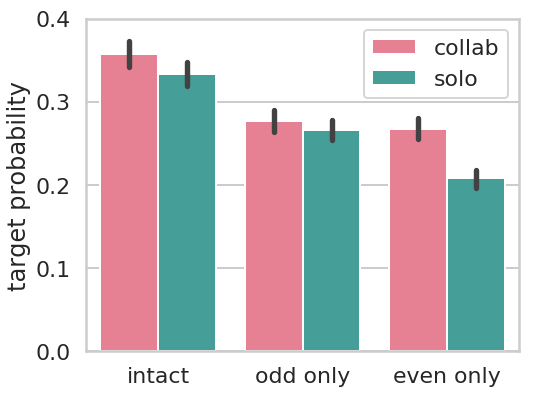

In [22]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.barplot(data=X,
                palette='husl',
                hue='condition',
                x='sketch_type',
                y='target_prob',
                hue_order=['collab','solo'])
plt.legend(bbox_to_anchor=(1.0,1))
plt.ylabel('target probability')
plt.xlabel('')
plt.yticks(np.linspace(0,0.4,5))
plt.tight_layout()
out_path = os.path.join(plot_dir,'sketch_lesion_bar_probability.pdf')
plt.savefig(out_path)

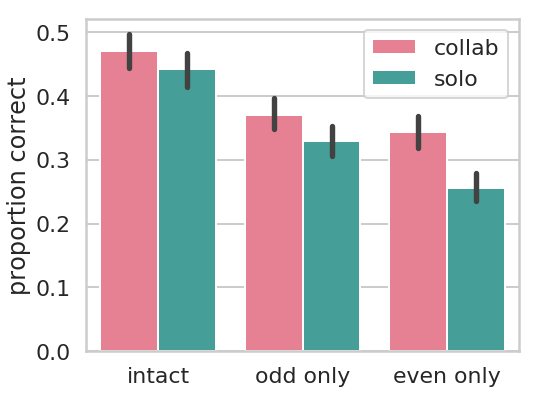

In [23]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid')
b = sns.barplot(data=X,
                palette='husl',
                hue='condition',
                x='sketch_type',
                y='correct',
                hue_order=['collab','solo'])
plt.legend(bbox_to_anchor=(1.,1))
plt.ylabel('proportion correct')
plt.xlabel('')
plt.tight_layout()
out_path = os.path.join(plot_dir,'sketch_lesion_bar_accuracy.pdf')
plt.savefig(out_path)

In [24]:
X = pd.concat([CPT,CHT,CRT,SET,SOT],axis=0)
## get target prob means by condition 
X.groupby(['sketch_type','condition'])['target_prob'].mean()

sketch_type  condition
even only    collab       0.267383
             solo         0.207903
intact       collab       0.357097
             solo         0.332840
odd only     collab       0.276958
             solo         0.266544
Name: target_prob, dtype: float64

In [25]:
## get bootstrapped 95% CI for target prob means by condition
def get_stratified_bootstrap_by_condition(X,nIter=1000,cond='collab'):
    boot_mean = []
    for currIter in np.arange(nIter):
        print('Running bootstrap iteration {}'.format(currIter))
        clear_output(wait=True)
        bootX = X.groupby(['condition','className']).apply(lambda x: x.sample(n=len(x), replace=True, random_state=currIter))
        boot_mean.append(bootX.groupby('condition')['target_prob'].mean()[cond])
    return boot_mean

## print out 95% CI
def get_bounds95(x):    
    return np.percentile(x,2.5), np.percentile(x,97.5)

def print_95ci(boot_mean):
    lb,ub = get_bounds95(boot_mean)
    print '95% CI: [{},{}]'.format(lb.round(5),ub.round(5))    


In [26]:
### intact
boot_collab = get_stratified_bootstrap_by_condition(CPT,cond='collab')
boot_solo = get_stratified_bootstrap_by_condition(CPT,cond='solo')
print 'intact: collab'
print_95ci(boot_collab)
print 'intact: solo'
print_95ci(boot_solo)

intact: collab
95% CI: [0.33929,0.37418]
intact: solo
95% CI: [0.31557,0.34965]


In [27]:
### collab human only
boot_collab_human = get_stratified_bootstrap_by_condition(CHT,cond='collab')
print 'collab human only'
print_95ci(boot_collab_human)

collab human only
95% CI: [0.26416,0.29074]


In [28]:
### collab model only
boot_collab_model = get_stratified_bootstrap_by_condition(CRT,cond='collab')
print 'collab model only'
print_95ci(boot_collab_model)

collab model only
95% CI: [0.25524,0.27978]


In [29]:
### solo odd only
boot_solo_odd = get_stratified_bootstrap_by_condition(SOT,cond='solo')
print 'solo odd only'
print_95ci(boot_solo_odd)

solo odd only
95% CI: [0.25376,0.27948]


In [30]:
### solo even only
boot_solo_even = get_stratified_bootstrap_by_condition(SET,cond='solo')
print 'solo even only'
print_95ci(boot_solo_even)

solo even only
95% CI: [0.19821,0.21792]


#### broken out by category

##### COLLAB HUMAN ONLY

<Figure size 432x288 with 0 Axes>

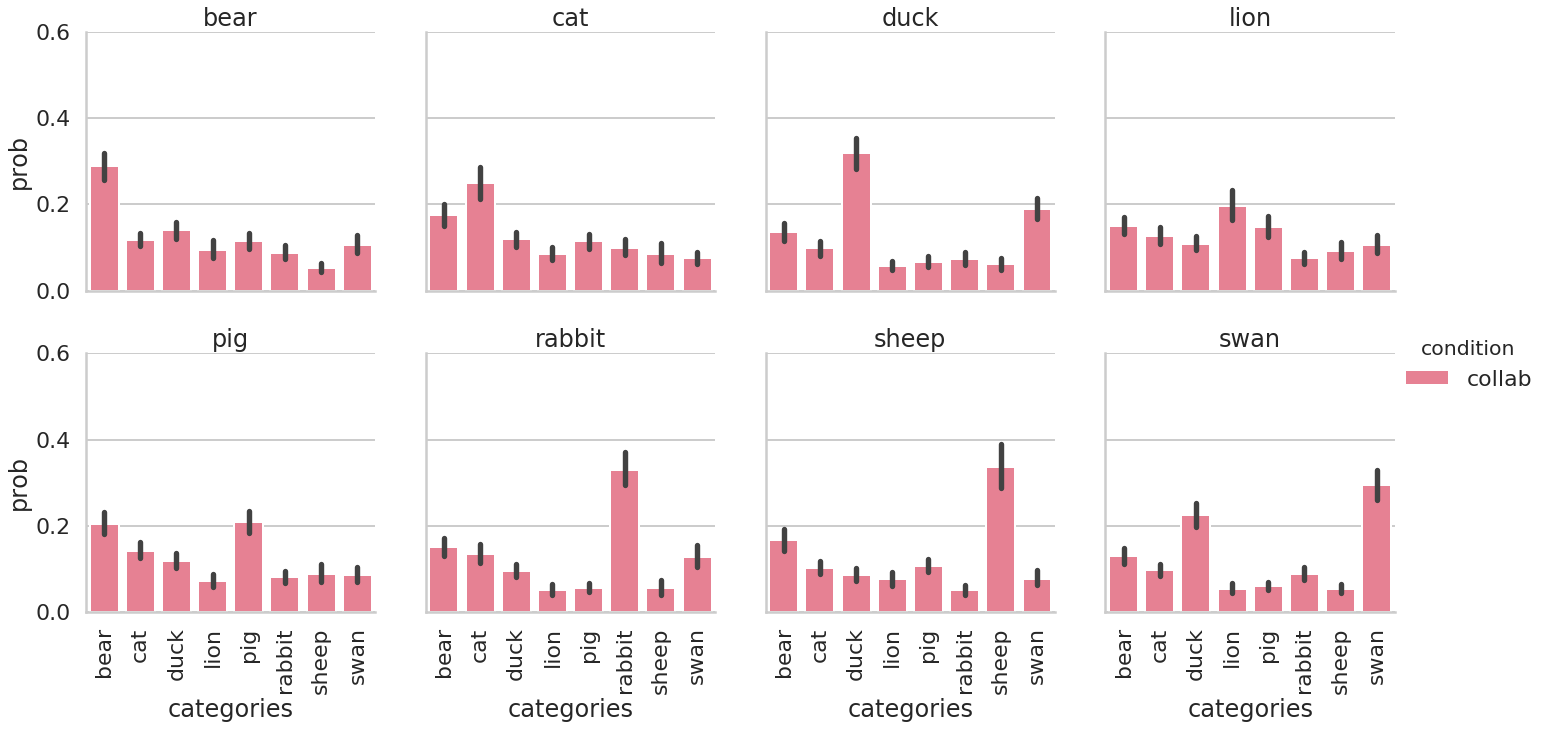

In [31]:
CHP = plot_probs_by_class(clf,CH)

##### COLLAB ROBOT ONLY

<Figure size 432x288 with 0 Axes>

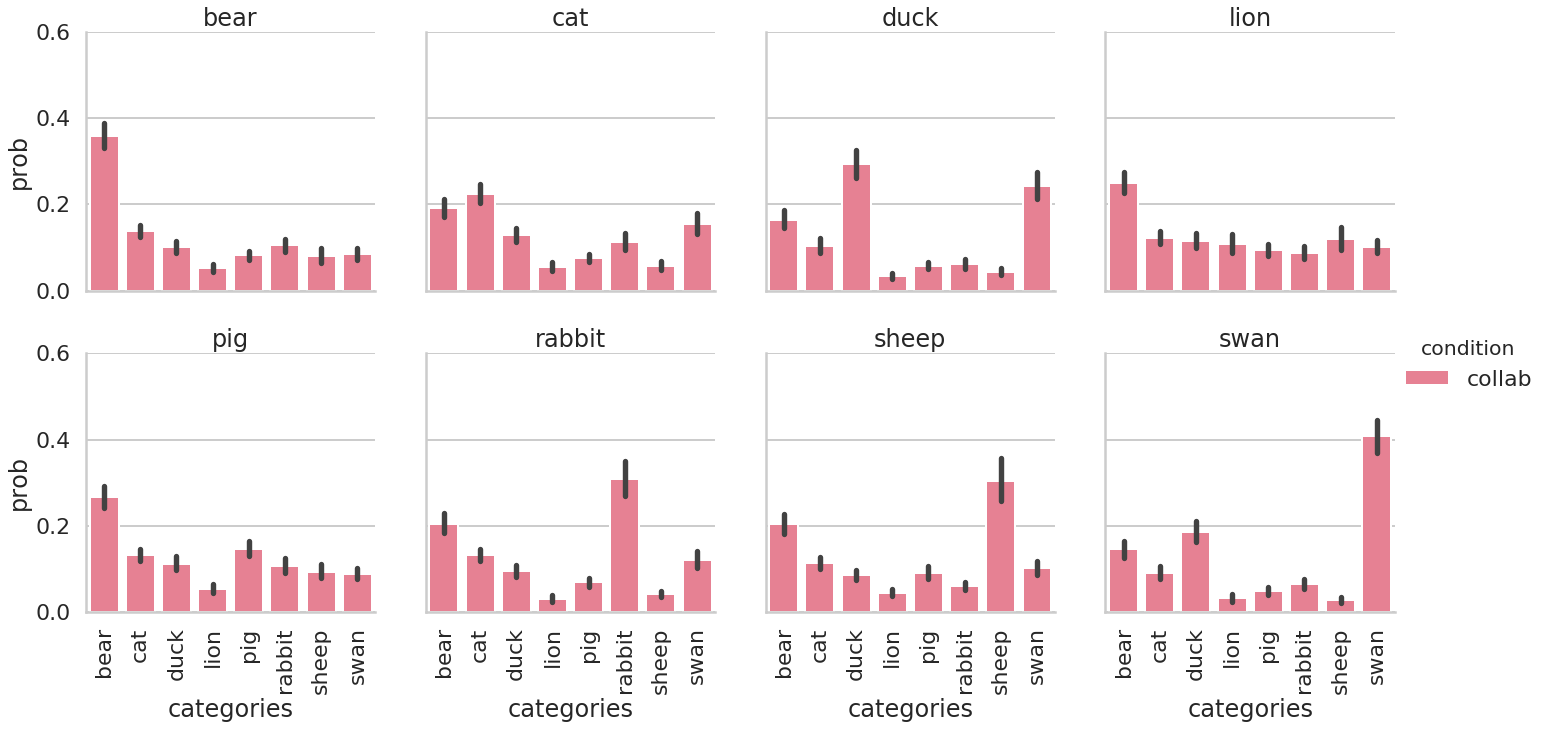

In [32]:
CRP = plot_probs_by_class(clf,CR)

##### SOLO EVEN ONLY

<Figure size 432x288 with 0 Axes>

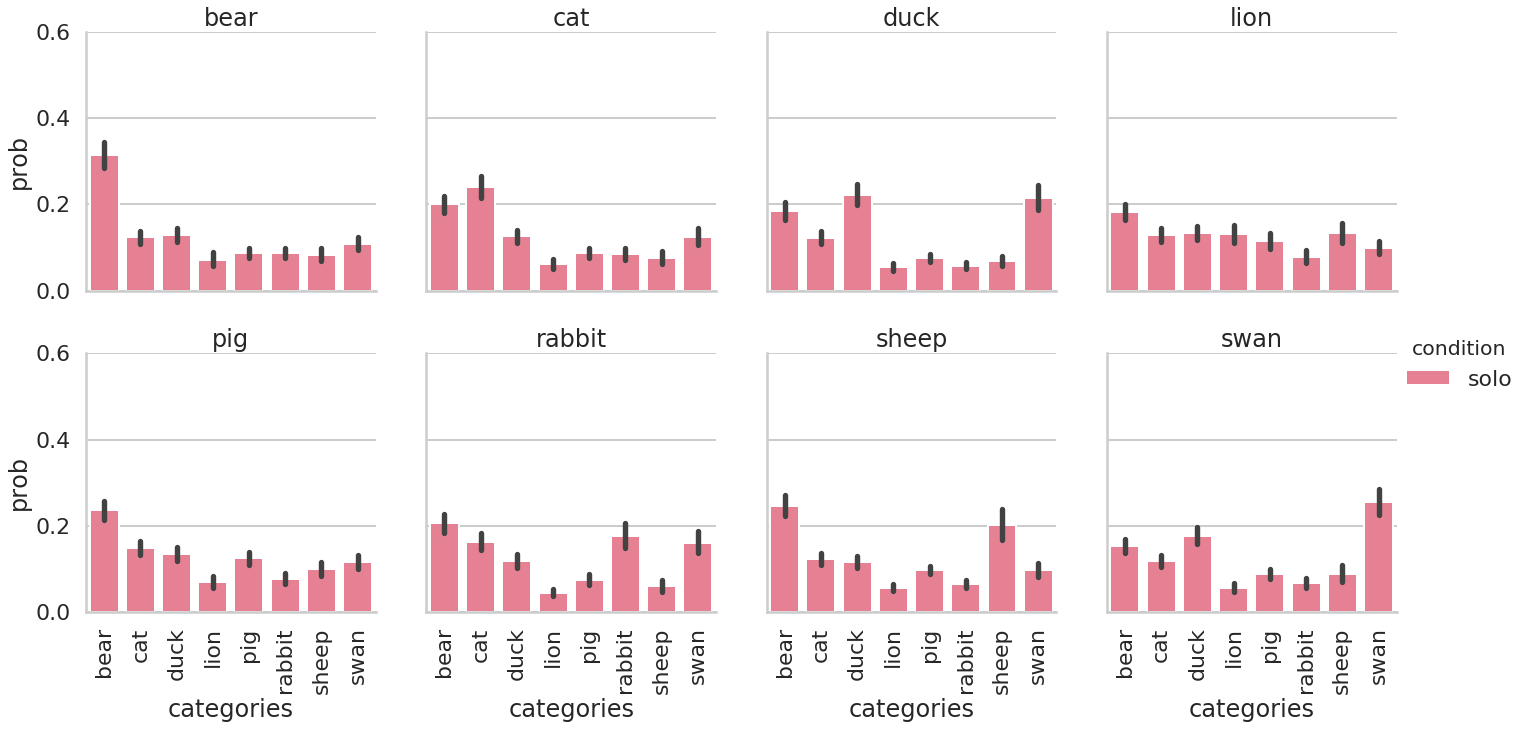

In [33]:
SEP = plot_probs_by_class(clf,SE)

##### SOLO ODD ONLY

<Figure size 432x288 with 0 Axes>

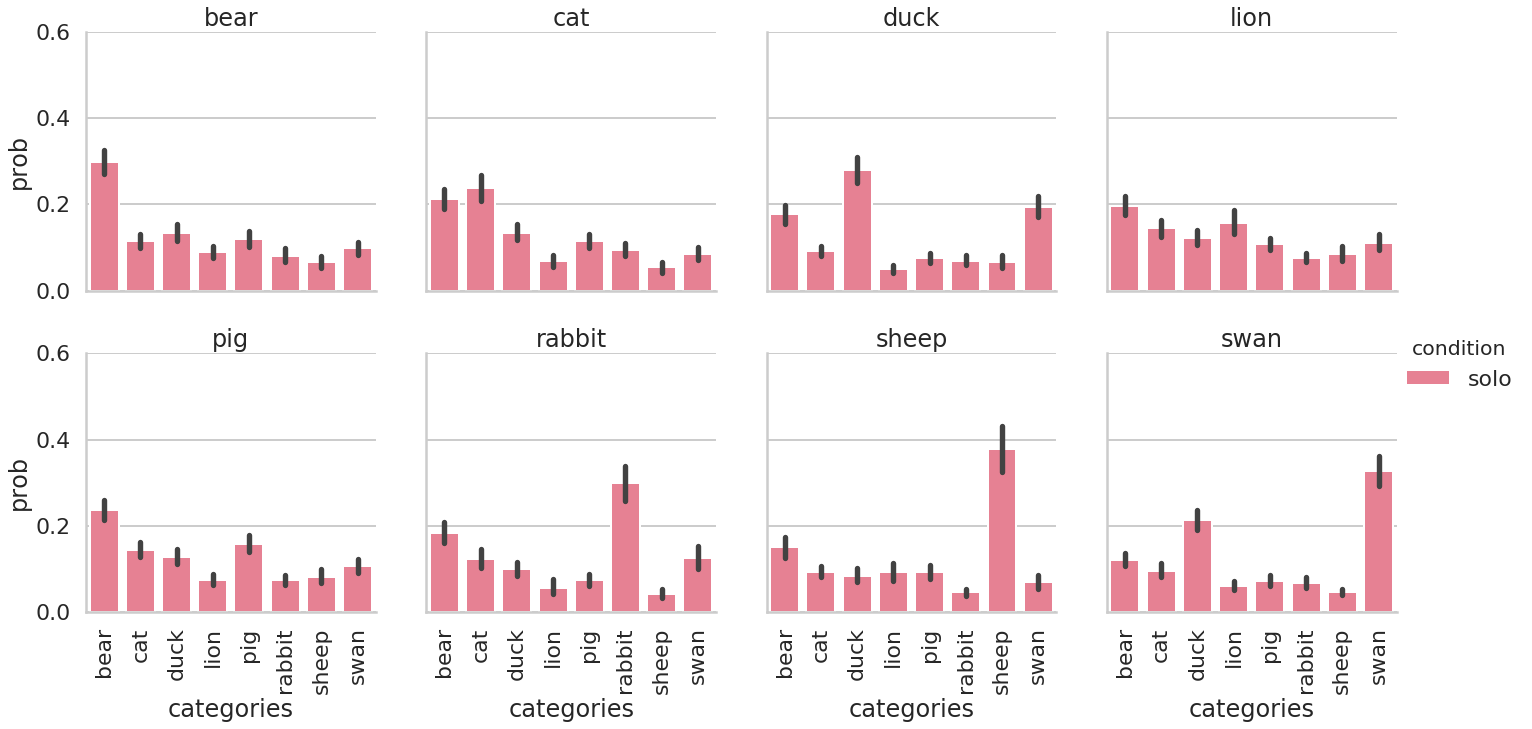

In [34]:
SOP = plot_probs_by_class(clf,SO)